# Rain Reports
Initial Development. <br>

TODO List: 
* Add more info in the tabular side of the report -> ok
* Make the report with the anomalies
* Refactor the code
* Rewrite the tests
* Write console activation
* Separate downloader from reporter
* Automate report generation for several basins at once
* Add reference layer -> ok

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import matplotlib.pyplot as plt

import pandas as pd
import geopandas as gpd
import contextily as cx

from raindownloader.parser import BaseParser
from raindownloader.inpeparser import INPE, INPEParsers, INPETypes
from raindownloader.inpedownloader import Downloader
from raindownloader.utils import FileType, DateProcessor, DateFrequency
from rainreporter.reporter import RainReporter

import rasterio as rio
import xarray as xr
from raindownloader.utils import GISUtil

## Testing Monthly Accumulated Parser

In [2]:
downloader = Downloader(
    server=INPE.FTPurl,
    parsers=INPEParsers.parsers,
    post_processors=INPEParsers.post_processors
)


In [3]:
files = downloader.download_range('20230101', '2023-12', local_folder='../tmp', datatype=INPETypes.MONTHLY_ACUM)

In [4]:
files

[PosixPath('../tmp/MERGE_CPTEC_acum_jan.nc'),
 PosixPath('../tmp/MERGE_CPTEC_acum_feb.nc'),
 PosixPath('../tmp/MERGE_CPTEC_acum_mar.nc'),
 PosixPath('../tmp/MERGE_CPTEC_acum_apr.nc'),
 PosixPath('../tmp/MERGE_CPTEC_acum_may.nc'),
 PosixPath('../tmp/MERGE_CPTEC_acum_jun.nc'),
 PosixPath('../tmp/MERGE_CPTEC_acum_jul.nc'),
 PosixPath('../tmp/MERGE_CPTEC_acum_aug.nc'),
 PosixPath('../tmp/MERGE_CPTEC_acum_sep.nc'),
 PosixPath('../tmp/MERGE_CPTEC_acum_oct.nc'),
 PosixPath('../tmp/MERGE_CPTEC_acum_nov.nc'),
 PosixPath('../tmp/MERGE_CPTEC_acum_dec.nc')]

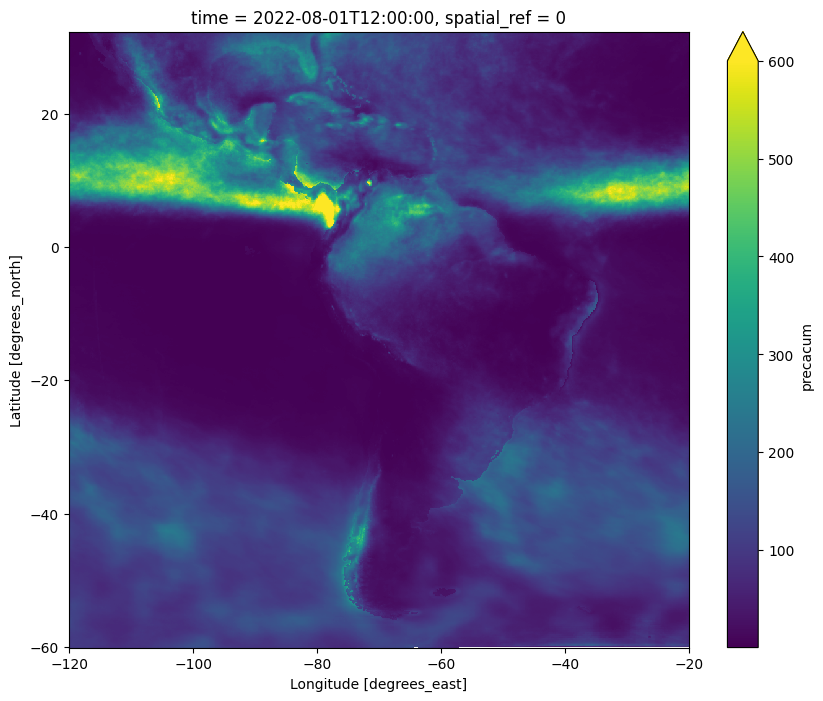

In [5]:
file = downloader.download_file('2023-08', local_folder='../tmp', datatype=INPETypes.MONTHLY_ACUM)
ma = downloader.open_file(file)[INPETypes.MONTHLY_ACUM.value]
ma.plot(figsize=(10, 8), vmax=600)

In [6]:
file = downloader.download_file('20230101', local_folder='../tmp', datatype=INPETypes.MONTHLY_ACCUM_YEARLY)
may = downloader.open_file(file)[INPETypes.MONTHLY_ACCUM_YEARLY.value]

In [7]:
file = downloader.download_file('20230101', local_folder='../tmp', datatype=INPETypes.DAILY_AVERAGE)
daily_average = downloader.open_file(file)[INPETypes.DAILY_AVERAGE.value]

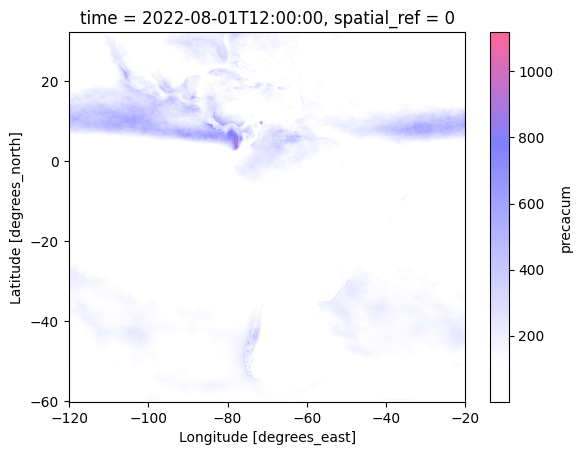

In [8]:
ma.plot(cmap=INPE.cmap)

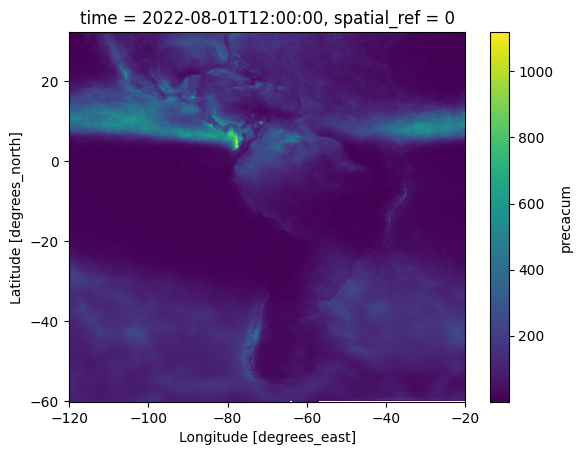

In [9]:
ma.plot()

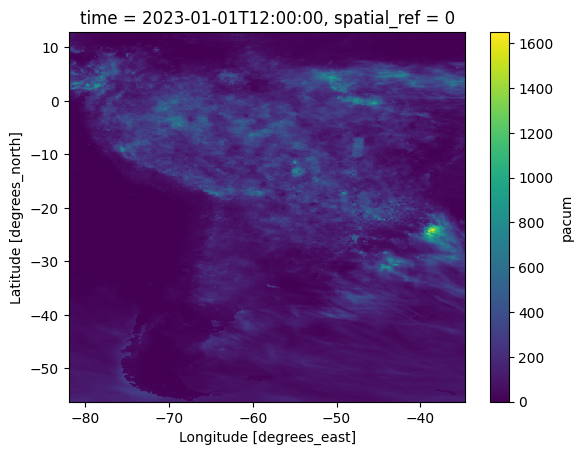

In [10]:
may.plot()

In [11]:
may.rio.crs

CRS.from_epsg(4326)

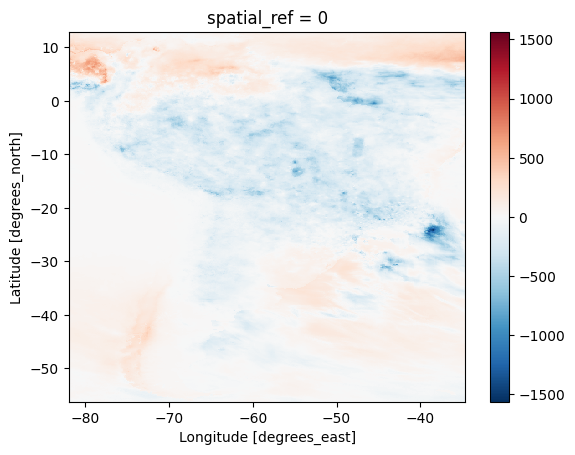

In [12]:
(ma.squeeze() - may.squeeze()).plot()

## Create Anomaly Report

In [17]:
month = 3
year = 2023

[autoreload of raindownloader.parser failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/extensions/autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.10/dist-packages/IPython/extensions/autoreload.py", line 471, in superreload
    module = reload(module)
  File "/usr/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1017, in get_code
  File "<frozen importlib._bootstrap_external>", line 947, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/workspaces/INPERainDownloader/raindownloader/parser.py", line 39
    remote_file = 
                  ^
SyntaxError: invalid syntax
]


In [19]:
INPETypes.DAILY_RAIN.name

'DAILY_RAIN'

: 

In [14]:
reporter = RainReporter(
    server=INPE.FTPurl,
    download_folder='../tmp',
    post_processors=INPEParsers.post_processors,
    parsers=INPEParsers.parsers
)

In [15]:
cube = reporter.get_cube('20220301', '20230301', datatype=INPETypes.DAILY_RAIN)

In [16]:
cube

<xarray.DataArray 'prec' (time: 366, latitude: 924, longitude: 1001)>
array([[[ 0.0625,  0.0625,  0.0625, ...,  1.375 ,  1.1875,  1.25  ],
        [ 0.0625,  0.125 ,  0.0625, ...,  1.3125,  1.625 ,  1.75  ],
        [ 0.125 ,  0.125 ,  0.125 , ...,  1.3125,  1.25  ,  1.5625],
        ...,
        [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.1875,  0.1875],
        [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.125 ,  0.0625],
        [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.0625,  0.    ]],

       [[ 0.    ,  0.125 ,  0.125 , ...,  6.5   ,  7.625 , 10.75  ],
        [ 0.375 ,  0.25  ,  0.375 , ...,  8.375 ,  8.5   ,  9.    ],
        [ 0.125 ,  0.25  ,  0.25  , ...,  8.    ,  9.125 ,  9.5   ],
        ...,
        [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.125 ],
        [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.125 ]],

       [[ 0.5625,  0.    ,  0.    , ...,  1.3125,  1.6875,  1.875 ],
        [ 0.    ,  0.    ,  0.    , ...,  1.3125,  1.1875,  1.3125],
        [ 0.    ,  0.    ,  0.    , ...,  1.    ,  1.    ,  1.    ],
        ...,
...
        [ 0.3125,  0.25  ,  0.1875, ...,  0.0625,  0.    ,  0.    ],
        [ 0.25  ,  0.1875,  0.    , ...,  0.25  ,  0.1875,  0.125 ],
        [ 0.1875,  0.    ,  0.    , ...,  0.3125,  0.25  ,  0.1875]],

       [[ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    , ...,  0.125 ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    , ...,  0.125 ,  0.    ,  0.    ],
        ...,
        [ 0.25  ,  0.1875,  0.25  , ...,  0.6875,  0.5   ,  0.5625],
        [ 0.375 ,  0.25  ,  0.3125, ...,  0.0625,  0.25  ,  0.4375],
        [ 0.4375,  0.5   ,  0.4375, ...,  0.125 ,  0.125 ,  0.1875]],

       [[ 0.125 ,  0.125 ,  0.125 , ...,  0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.125 , ...,  0.    ,  0.    ,  0.    ],
        [ 0.125 ,  0.125 ,  0.    , ...,  0.    ,  0.    ,  0.    ],
        ...,
        [ 0.375 ,  0.125 ,  0.125 , ...,  0.125 ,  0.125 ,  0.125 ],
        [ 0.25  ,  0.25  ,  0.25  , ...,  0.125 ,  0.    ,  0.    ],
        [ 0.375 ,  0.375 ,  0.625 , ...,  0.125 ,  0.    ,  0.    ]]],
      dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 2022-03-01T12:00:00 ... 2023-03-01T12:...
    step         timedelta64[ns] 00:00:00
    surface      float64 0.0
  * latitude     (latitude) float64 -60.05 -59.95 -59.85 ... 32.05 32.15 32.25
  * longitude    (longitude) float64 -120.1 -120.0 -119.9 ... -20.15 -20.05
    valid_time   (time) datetime64[ns] 2022-03-01T12:00:00 ... 2023-03-01T12:...
    spatial_ref  int64 0
Attributes: (12/29)
    GRIB_paramId:                             260138
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      924924
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_name:                                Precipitation
    GRIB_shortName:                           prec
    GRIB_units:                               kg m**-2
    long_name:                                Precipitation
    units:                                    kg m**-2
    standard_name:                            unknown

In [18]:
cube2 = reporter.get_cube('20220301', '20220631', datatype=INPETypes.DAILY_RAIN)

ParserError: day is out of range for month: 20220631

In [16]:
cube

<xarray.DataArray 'prec' (time: 184, latitude: 924, longitude: 1001)>
array([[[ 0.0625,  0.0625,  0.0625, ...,  1.375 ,  1.1875,  1.25  ],
        [ 0.0625,  0.125 ,  0.0625, ...,  1.3125,  1.625 ,  1.75  ],
        [ 0.125 ,  0.125 ,  0.125 , ...,  1.3125,  1.25  ,  1.5625],
        ...,
        [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.1875,  0.1875],
        [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.125 ,  0.0625],
        [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.0625,  0.    ]],

       [[ 0.    ,  0.125 ,  0.125 , ...,  6.5   ,  7.625 , 10.75  ],
        [ 0.375 ,  0.25  ,  0.375 , ...,  8.375 ,  8.5   ,  9.    ],
        [ 0.125 ,  0.25  ,  0.25  , ...,  8.    ,  9.125 ,  9.5   ],
        ...,
        [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.125 ],
        [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.125 ]],

       [[ 0.5625,  0.    ,  0.    , ...,  1.3125,  1.6875,  1.875 ],
        [ 0.    ,  0.    ,  0.    , ...,  1.3125,  1.1875,  1.3125],
        [ 0.    ,  0.    ,  0.    , ...,  1.    ,  1.    ,  1.    ],
        ...,
...
        [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ]],

       [[ 0.    ,  0.    ,  0.    , ...,     nan,     nan,     nan],
        [ 0.    ,  0.    ,  0.125 , ...,  0.125 ,  0.125 ,  0.25  ],
        [ 0.    ,  0.    ,  0.125 , ...,  0.25  ,  0.25  ,  0.25  ],
        ...,
        [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ]],

       [[ 0.    ,  0.    ,  0.    , ...,     nan,     nan,     nan],
        [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
        ...,
        [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ]]],
      dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 2022-03-01T12:00:00 ... 2022-08-31T12:...
    step         timedelta64[ns] 00:00:00
    surface      float64 0.0
  * latitude     (latitude) float64 -60.05 -59.95 -59.85 ... 32.05 32.15 32.25
  * longitude    (longitude) float64 -120.1 -120.0 -119.9 ... -20.15 -20.05
    valid_time   (time) datetime64[ns] 2022-03-01T12:00:00 ... 2022-08-31T12:...
    spatial_ref  int64 0
Attributes: (12/29)
    GRIB_paramId:                             260138
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      924924
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_name:                                Precipitation
    GRIB_shortName:                           prec
    GRIB_units:                               kg m**-2
    long_name:                                Precipitation
    units:                                    kg m**-2
    standard_name:                            unknown

In [29]:
march = reporter.get_cube('20220301', '20220331', datatype=INPETypes.MONTHLY_ACCUM_YEARLY)

In [74]:
# cut the cube to the size of the climatology
# the nearest method is used because of floating point differences in longitude that can be disconsidered
cube = cube.sel({'longitude': march['longitude'], 'latitude': march['latitude']}, method='nearest')

In [75]:
cube.mean(dim=['longitude', 'latitude']).sum()

<xarray.DataArray 'prec' ()>
array(149.97906, dtype=float32)
Coordinates:
    step         timedelta64[ns] 00:00:00
    surface      float64 0.0
    spatial_ref  int64 0

In [31]:
march.mean()

<xarray.DataArray 'pacum' ()>
array(149.97908, dtype=float32)
Coordinates:
    spatial_ref  int64 0

In [34]:
march

<xarray.DataArray 'pacum' (time: 1, latitude: 691, longitude: 474)>
array([[[143.875 , 144.1875, 146.75  , ..., 123.125 , 125.375 ,
         121.3125],
        [149.1875, 147.75  , 151.625 , ..., 132.0625, 131.4375,
         124.25  ],
        [152.4375, 156.    , 157.5   , ..., 151.125 , 137.125 ,
         139.125 ],
        ...,
        [ 19.6875,  25.5   ,  24.1875, ...,   2.4375,   2.    ,
           2.4375],
        [ 21.9375,  27.875 ,  27.375 , ...,   0.875 ,   1.125 ,
           1.3125],
        [ 17.1875,  24.4375,  24.875 , ...,   0.9375,   1.6875,
           1.4375]]], dtype=float32)
Coordinates:
  * longitude    (longitude) float64 -81.95 -81.85 -81.75 ... -34.75 -34.65
  * latitude     (latitude) float64 -56.15 -56.05 -55.95 ... 12.65 12.75 12.85
  * time         (time) datetime64[ns] 2022-03-01T12:00:00
    spatial_ref  int64 0

## Create the Animation Cube

In [17]:
files = downloader.download_range('20230101', '2023-12', local_folder='../tmp', datatype=INPETypes.MONTHLY_ACUM)
cube = downloader.create_cube(files)[INPETypes.MONTHLY_ACUM.value]

In [18]:
# set the limits for the colorbar
vmin = 0
vmax = float(cube.max()) * 0.7
vmax=600

In [17]:
import io
from PIL import Image

file_name = 'rain_animation.gif'

# create a figure to be used as a canvas
fig = plt.figure()

# create a list to store the temporary in-memory files
files = []
for time in cube.time.data:
    plt_ax = fig.add_subplot()
    cube.sel(time=time).plot(ax=plt_ax, vmin=vmin, vmax=vmax)

    # Create a temporary file
    file_like = io.BytesIO()

    fig.savefig(file_like)
    files.append(file_like)
    fig.clear()

# Now, with the files created in memory, let's use PIL to save the GIF
images = []
for file in files:
    img = Image.open(file)
    images.append(img)

images[0].save(
    file_name,
    save_all=True,
    append_images=images[1:],
    duration=300,
    loop=1,
)


<Figure size 640x480 with 0 Axes>

In [2]:
7*3.5*1.5

36.75

In [3]:
36*6

216

In [19]:
cube['time']

<xarray.DataArray 'time' (time: 12)>
array(['2022-01-01T12:00:00.000000000', '2022-02-01T12:00:00.000000000',
       '2022-03-01T12:00:00.000000000', '2022-04-01T12:00:00.000000000',
       '2022-05-01T12:00:00.000000000', '2022-06-01T12:00:00.000000000',
       '2022-07-01T12:00:00.000000000', '2022-08-01T12:00:00.000000000',
       '2022-09-01T12:00:00.000000000', '2022-10-01T12:00:00.000000000',
       '2022-11-01T12:00:00.000000000', '2022-12-01T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time         (time) datetime64[ns] 2022-01-01T12:00:00 ... 2022-12-01T12:...
    spatial_ref  int64 0
Attributes:
    long_name:  Time

In [20]:
cube.sel({'time': '2022-01-01T12:00:00.000000000' })

<xarray.DataArray 'precacum' (latitude: 924, longitude: 1001)>
array([[111.87216 , 131.85228 , 131.57103 , ...,  45.678978,  43.309658,
         42.72443 ],
       [133.94318 , 133.3892  , 133.2358  , ...,  43.301136,  41.795456,
         40.83807 ],
       [134.23296 , 134.65909 , 133.2642  , ...,  42.127842,  41.576706,
         40.451706],
       ...,
       [ 37.897728,  37.951706,  36.892044, ...,  40.159092,  41.173294,
         42.778408],
       [ 37.954544,  37.03125 ,  35.74432 , ...,  40.909092,  41.789772,
         41.451706],
       [ 37.454544,  36.43182 ,  36.83807 , ...,  40.835228,  42.508522,
         41.65057 ]], dtype=float32)
Coordinates:
  * longitude    (longitude) float64 -120.0 -119.9 -119.8 ... -20.15 -20.05
  * latitude     (latitude) float64 -60.05 -59.95 -59.85 ... 32.05 32.15 32.25
    time         datetime64[ns] 2022-01-01T12:00:00
    spatial_ref  int64 0